# Exploratory Data Analysis on PWM Behavioral Data

**Goal** This notebook will explore the features that predict time to train (TTT) and final hit rate.

Related notebooks:
* EDA_01_describe_perf.ipynb
* create_trained_threshold_df.ipynb

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd

from multiglm.data.dataset_loader import *
from multiglm.data import ANIMAL_IDS
from multiglm.models.linear_regression import *

sns.set_context("talk")

%load_ext autoreload
%autoreload 2

choice_palette = sns.color_palette("Set2", 3)

## Load In

In [16]:
full_df = DatasetLoader(
    animal_ids=ANIMAL_IDS,
    data_type="new_all",
).load_data()

trained_df = DatasetLoader(
    animal_ids=ANIMAL_IDS,
    data_type="new_trained",
).load_data()


trained_thresholds = pd.read_csv(
    "../data/processed/dataset_thresholding/threshold_sessions.csv"
)


def get_data_pre_trained(group):
    trained_session = trained_thresholds.query(
        "animal_id == @group.name"
    ).hit_threshold.values[0]

    return group.query("session < @trained_session")


pre_trained_df = (
    full_df.groupby("animal_id")
    .apply(get_data_pre_trained)
    .reset_index(drop=True)
    .copy()
)

Loading data for animal ids:  ['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']
Loading data for animal ids:  ['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']


## Time to Train

This analysis still need some more work- I'm not satisfied with the features being used quite yet, more notes in detail below.

### Features

Note there was a bug here and the features got deleted at some point and I didn't realize. They can be found in git history though.

<Axes: >

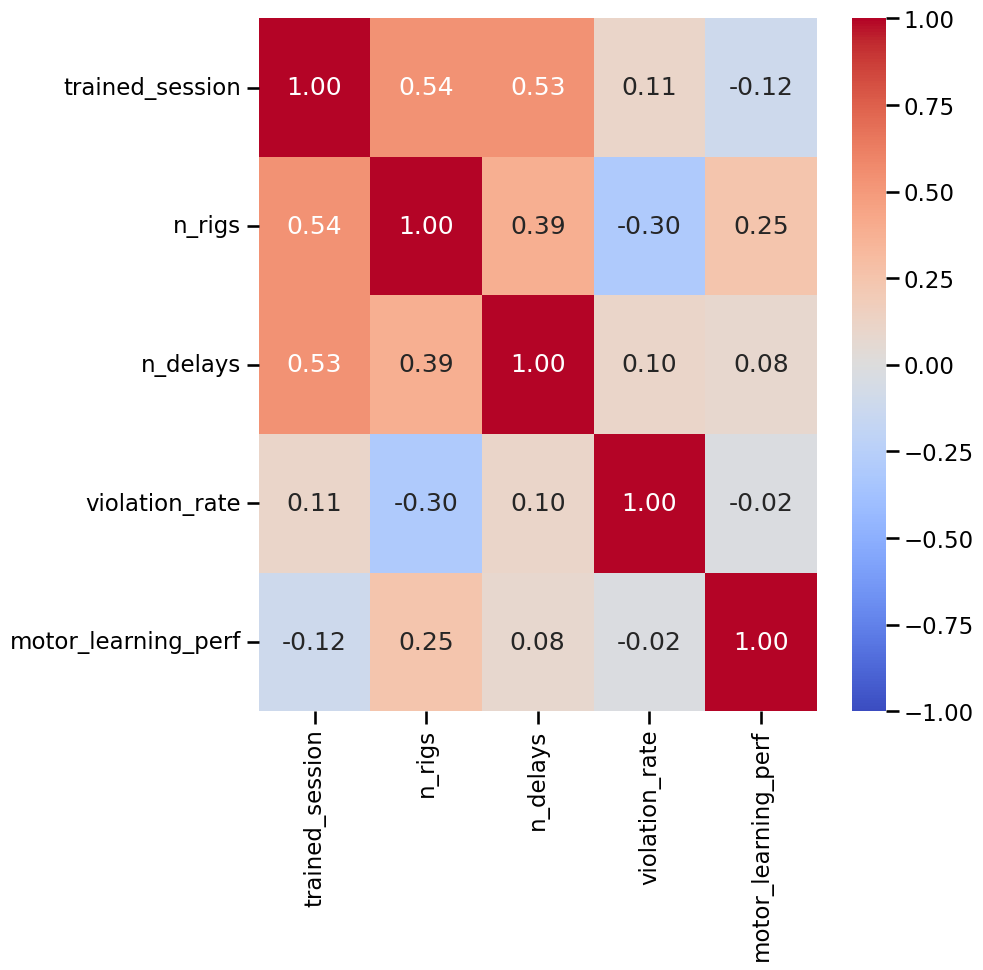

In [62]:
data_corr = data.query("animal_id != 'W082'").drop(columns="animal_id").corr()

fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(
    data_corr,
    center=0,
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
)

It looks like the number of rigs, number of delays are highly correlated with the time to train (trained session). Let's see what these look like in a pair plot.

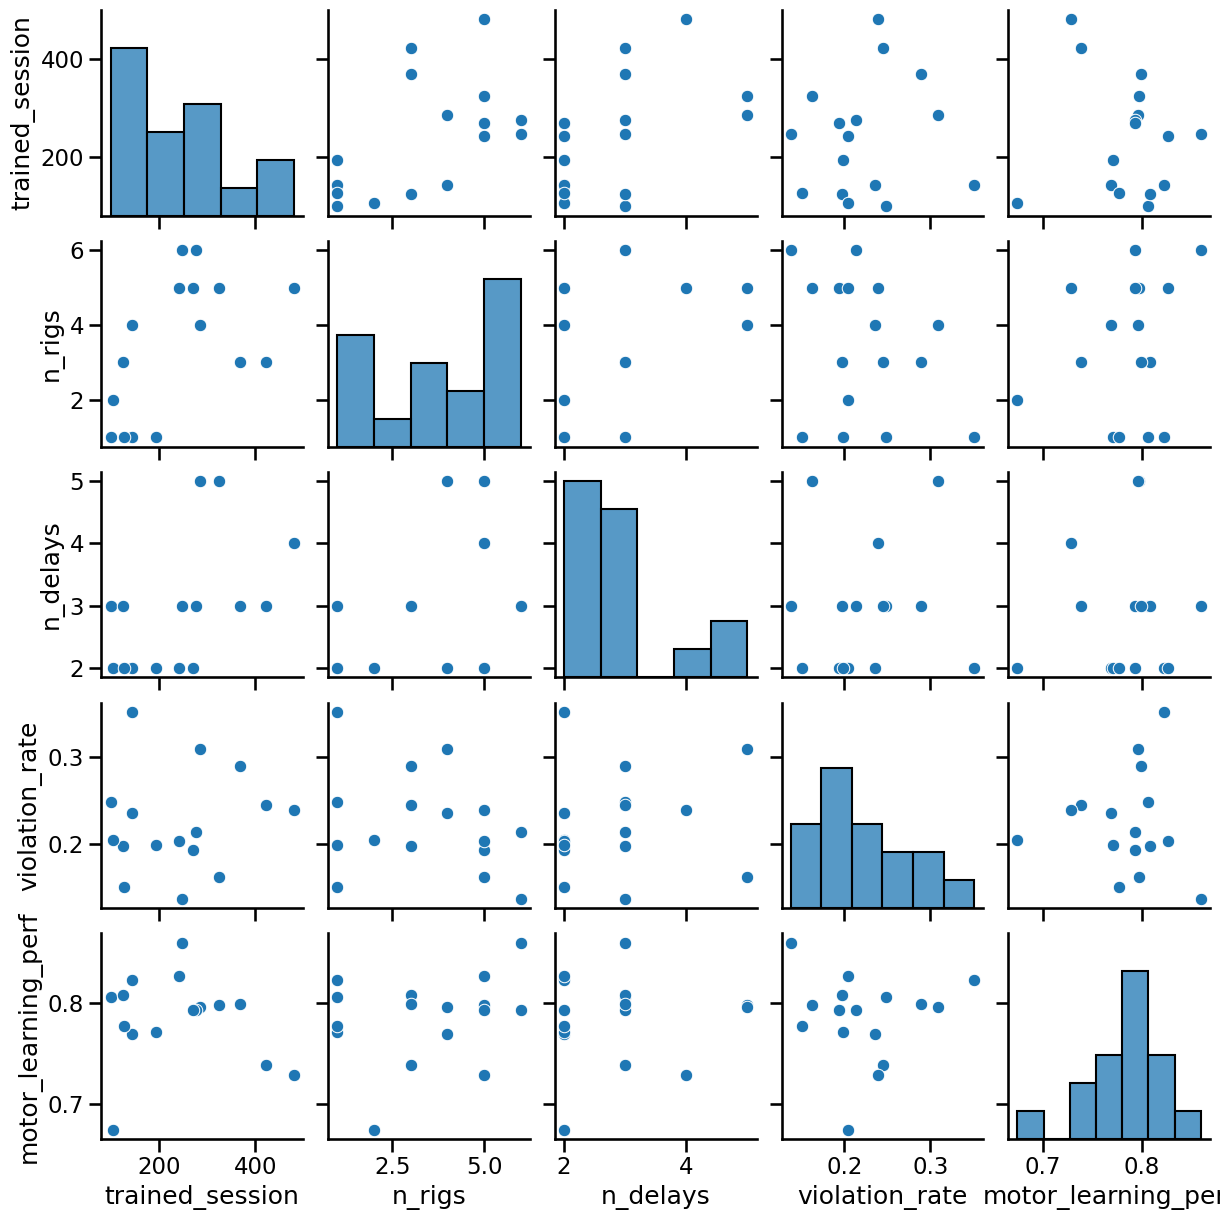

In [63]:
sns.pairplot(data)

The number of delays is a bit of a strange regressor. It makes sense that it's harder to learn the task if the enviornment is always changing, but it appears to be bimodel and with a small sample size, I don't feel like this is the best choice. I do think a better approach next time this notebook is revisted is to the average delay length (as done with predicting violation rate), or delay variability. 

### Predict

/Users/jessbreda/Desktop/github/animal-learning/src/multiglm/models/linear_regression.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


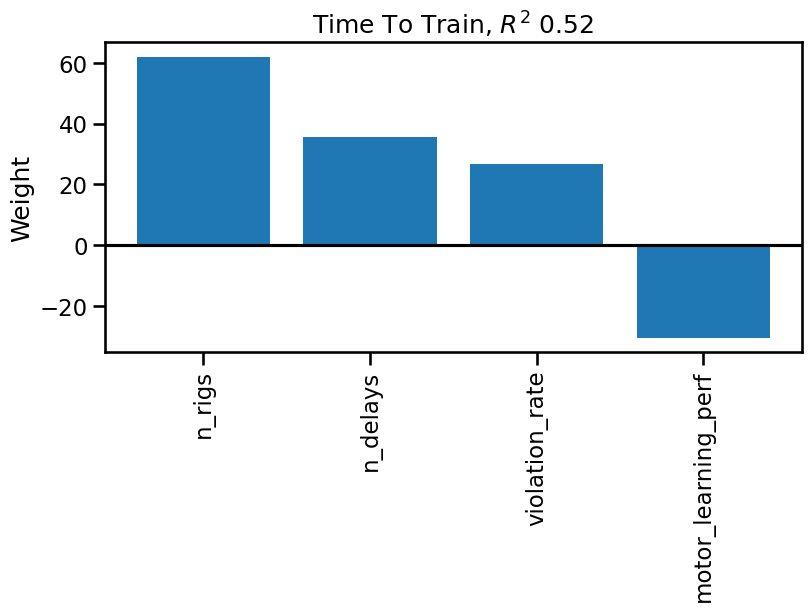

In [64]:
features = [
    column
    for column in data.columns.tolist()
    if column not in ["animal_id", "trained_session"]
]

predictor = "trained_session"

model, predict, rsq, rns, ws = fit_linear_model(
    data.query("animal_id != 'W082'"), predictor, features, whiten=True, plot=False
)

fig, ax = plt.subplots(1, 1, figsize=(8, 6), constrained_layout=True)
plot_weights(ax, rns, ws, f"Time To Train, $R^2$ {rsq:.2f}")
# plt.ylim(-0.05, 0.05)

(0.0, 0.5)

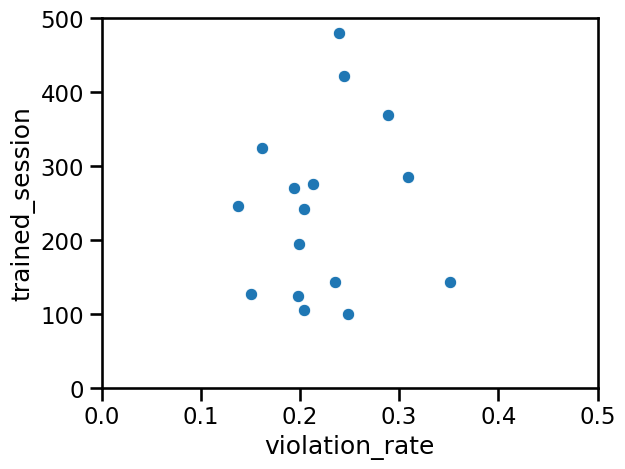

In [65]:
sns.scatterplot(data=data, x="violation_rate", y="trained_session")
plt.ylim(0, 500)
plt.xlim(0, 0.5)

Time to train is increased by: 
* number of rigs
* number of delays 
* violation rate

It is decerase by:
* motor learning performance

In summary- I think i need to revist this metric with more thoughtful regressors. Ie while I'm glad these are capturing some of the variability in the time to train, I don't think they are the best way to represent this information. As I mentioned above, avg delay length (or variance), number of rig switches, might be better. Moreover, I'm not sure to make of the motor learning performance since in some ways it is related to the final hit rate and that was what was used to determine training so it feels a bit circular. Best to let this sit for now and return to it another time.
 

In [66]:
data.to_csv("../data/processed/from_eda/02_predict_trained_session.csv", index=False)

## Final Hit Rate

The goal here is to predict the final hit rate given training features. An interesting thing to add here would be like the tau of the filtered history or the weight. I know these relationships are investigated in EDA-03, but not in a linear model.

In [80]:
data = pd.read_csv(
    "../data/processed/from_eda/01_trained_session_avg_hit_viol_rates.csv"
).drop(columns=["trained_violation"])


data["violation_rate"] = data["animal_id"].map(
    full_df.groupby(["animal_id", "session"])
    .violation.mean()
    .reset_index()
    .groupby("animal_id")
    .violation.mean()
)

data["time_to_train"] = data["animal_id"].map(
    trained_thresholds.set_index("animal_id").hit_threshold
)

data["motor_learning_perf"] = data["animal_id"].map(
    pre_trained_df.query("training_stage == 1")
    .groupby(["animal_id", "session"])
    .hit.mean()
    .reset_index()
    .groupby("animal_id")
    .hit.mean()
)

data["avg_delay_len"] = data["animal_id"].map(
    full_df.query("training_stage >=3")
    .groupby(["animal_id", "session"])
    .delay_time.mean()
    .reset_index()
    .groupby("animal_id")
    .delay_time.mean()
)


data.head()

,animal_id,trained_hit,trained_violation,time_to_train,motor_learning_perf,avg_delay_len
0,W051,0.796836,0.154370,325,0.973147,3.331276
1,W060,0.825368,0.149891,247,0.938054,3.071942
2,W065,0.775634,0.260626,100,0.961362,3.690211
3,W066,0.788768,0.253332,285,0.906446,4.078185
4,W068,0.778252,0.163857,422,0.942489,3.174428


<Axes: >

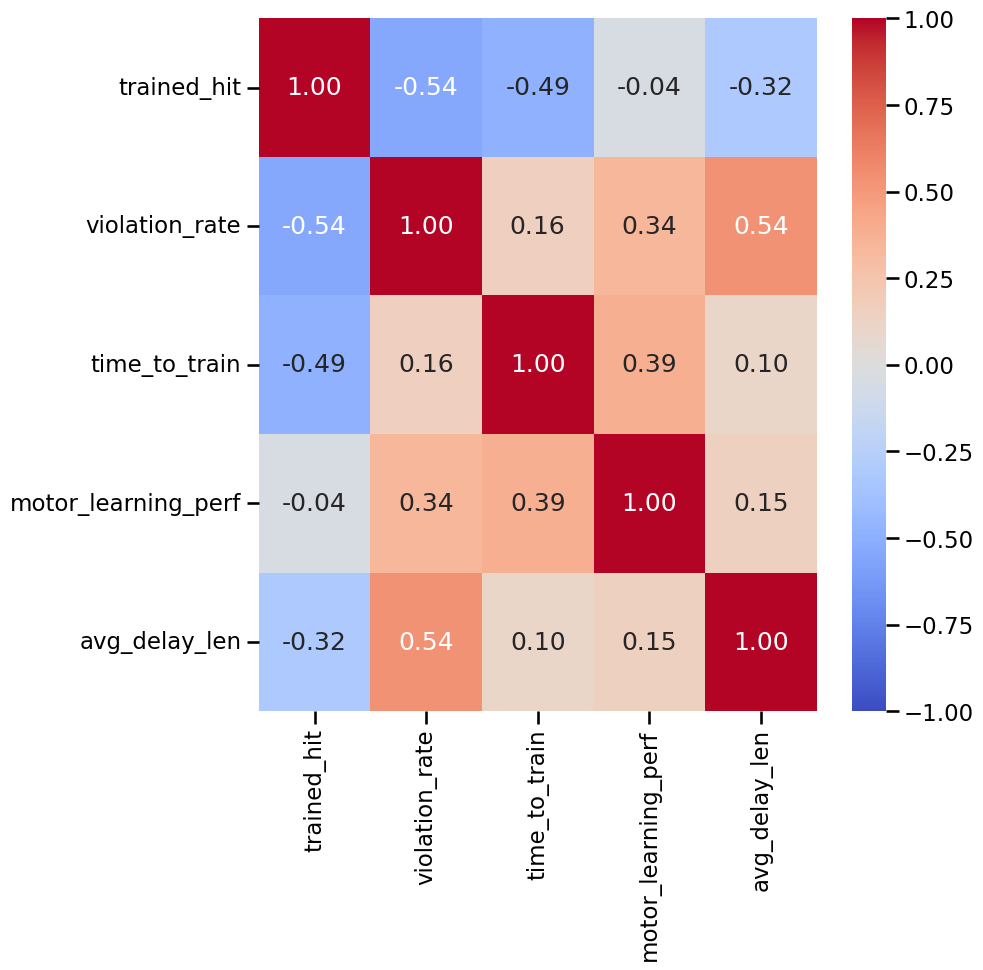

In [15]:
data_corr = data.drop(columns="animal_id").corr()

fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(
    data_corr,
    center=0,
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
)

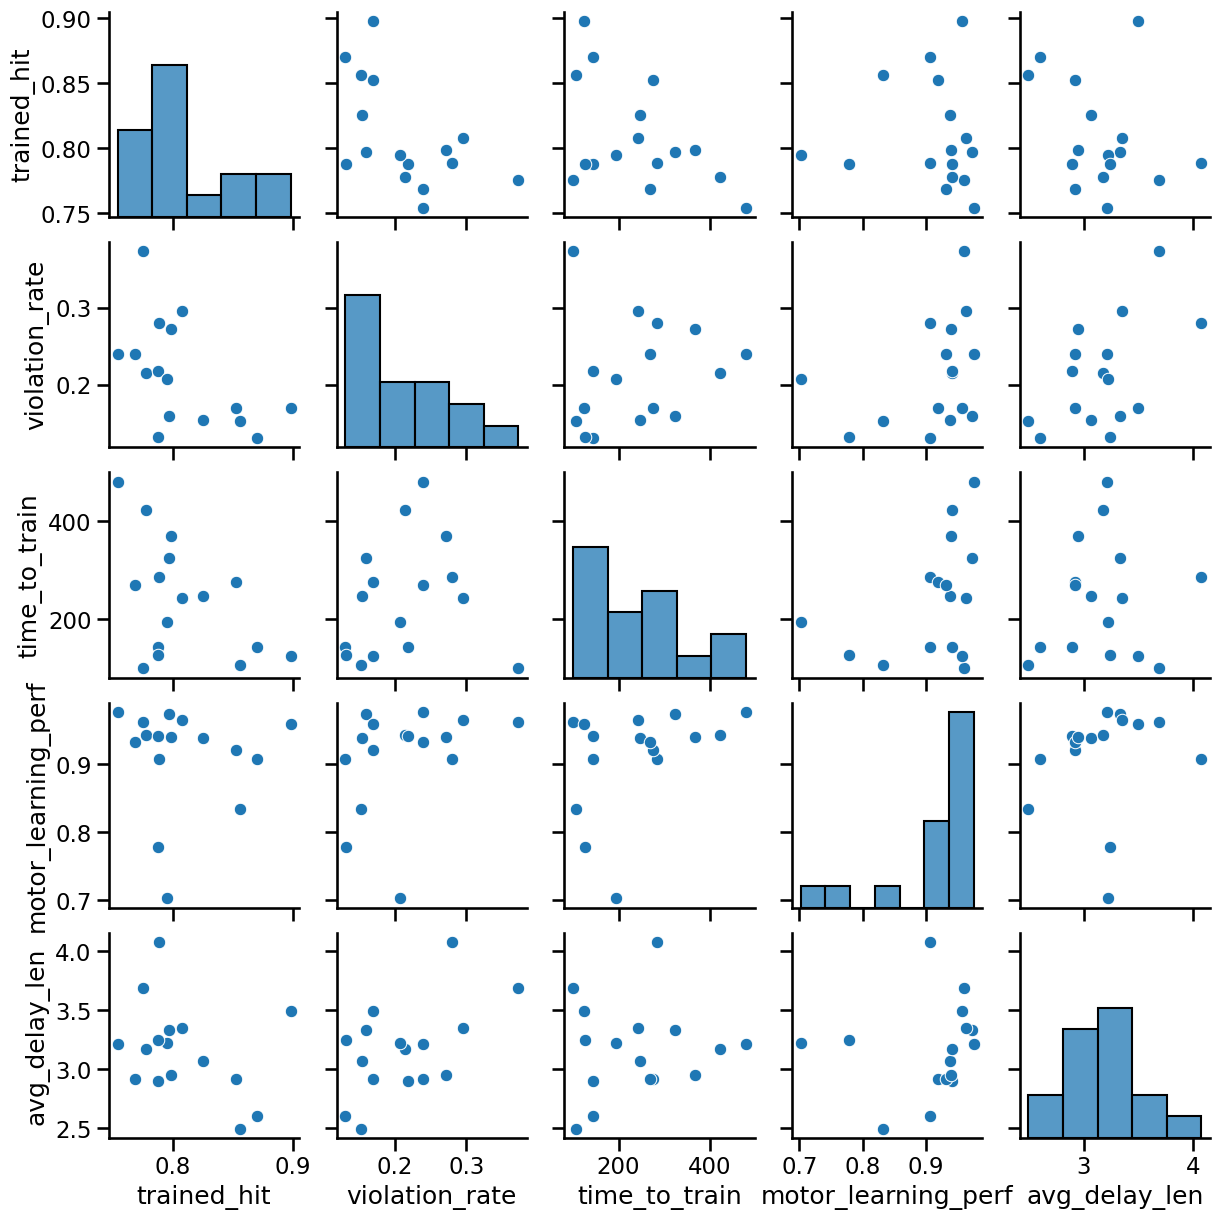

In [16]:
sns.pairplot(data)

Violation rate (across all sesssions) and time to train seem negatively correlated with the final performance. Again, i'm not sure if motor learning performance is a worthwhile regressor due to it's distribution. Moreover, this distribution looks different form the one in the time to train pair plot, so I'm dubious as to why that would happen. This feature is only looking at stage 1, but perhaps stage 2 was used in the other.

/Users/jessbreda/Desktop/github/animal-learning/src/multiglm/models/linear_regression.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


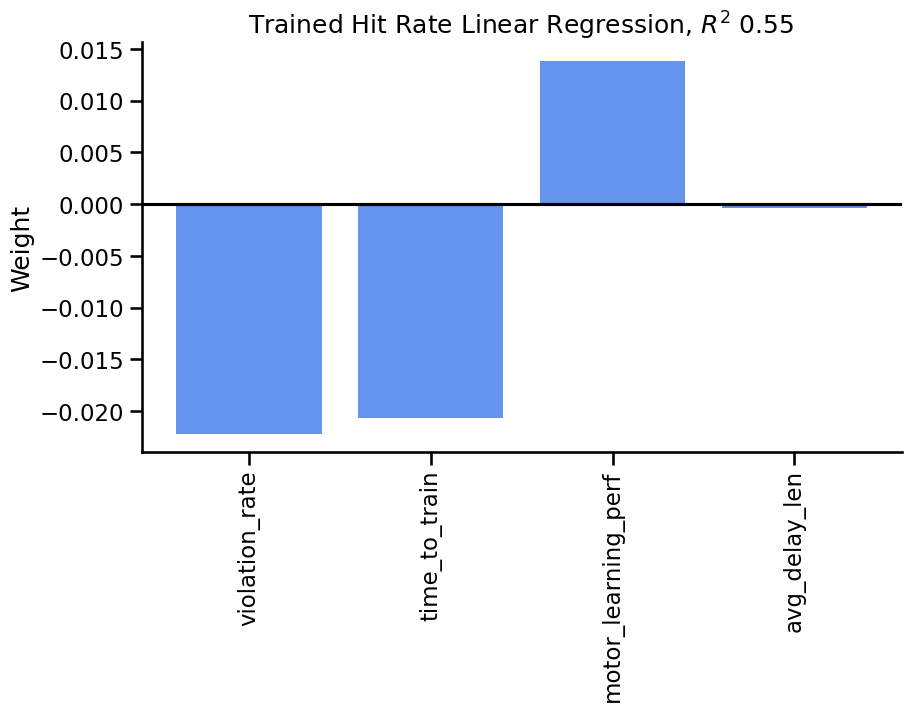

In [17]:
features = [
    column
    for column in data.columns.tolist()
    if column not in ["animal_id", "trained_hit"]
]

predictor = "trained_hit"

model, predict, rsq, rns, ws = fit_linear_model(
    data, predictor, features, whiten=True, plot=False
)

fig, ax = plt.subplots(1, 1, figsize=(9, 7), constrained_layout=True)
plot_weights(
    ax,
    rns,
    ws,
    f"Trained Hit Rate Linear Regression, $R^2$ {rsq:.2f}",
    color="cornflowerblue",
)
# plt.ylim(-0.05, 0.05)
sns.despine()

Violation rate and time to train are negatively correlated with final hit rate. Motor learning perf (again not sure why this is a regressor...) is positively correlated. Average delay length has a negligible weight. Let's look at univariate relationships in more detail to see what is happening.

(0.5, 1.0)

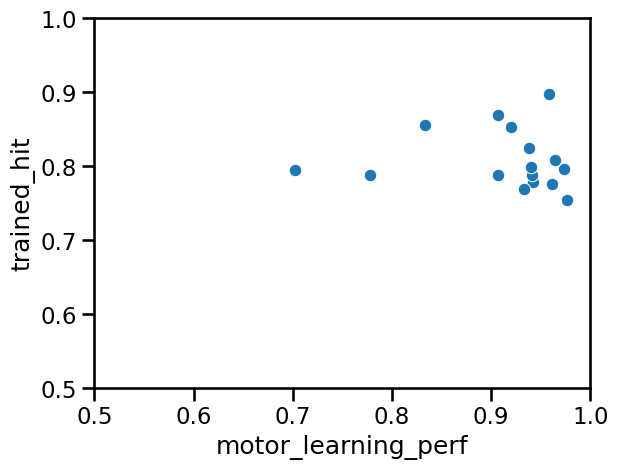

In [20]:
sns.scatterplot(data=data, x="motor_learning_perf", y="trained_hit")
plt.ylim(0.5, 1)
plt.xlim(0.5, 1)

(0.5, 1.0)

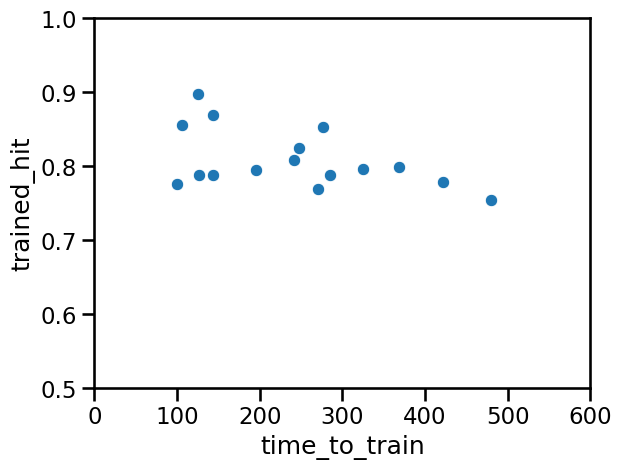

In [83]:
sns.scatterplot(data=data, x="time_to_train", y="trained_hit")
plt.xlim(0, 600)
plt.ylim(0.5, 1)

(0.5, 1.0)

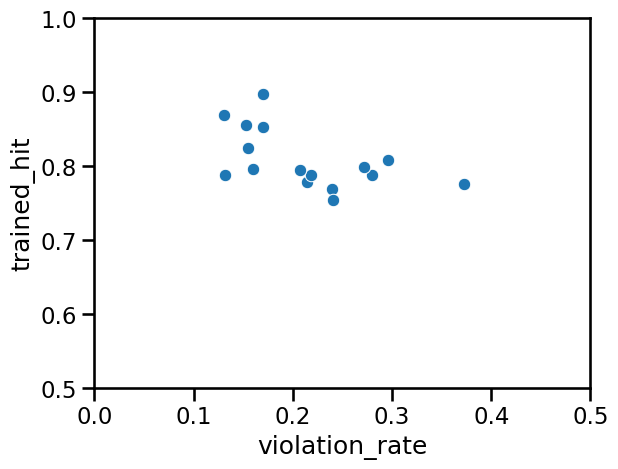

In [22]:
sns.scatterplot(data=data, x="violation_rate", y="trained_hit")
plt.xlim(0, 0.5)
plt.ylim(0.5, 1)

(0.5, 1.0)

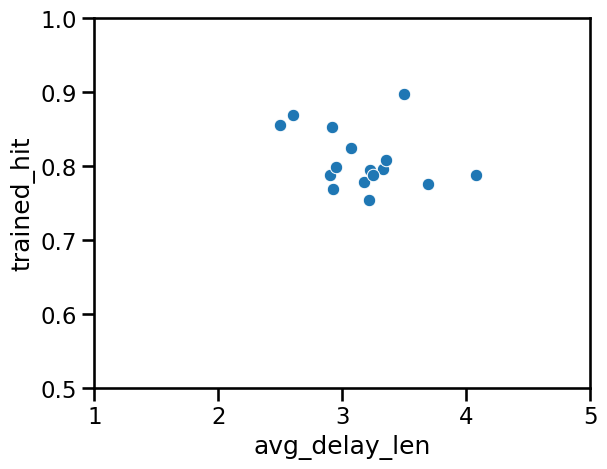

In [25]:
sns.scatterplot(data=data, x="avg_delay_len", y="trained_hit")
plt.xlim(1, 5)
plt.ylim(0.5, 1)

(0.0, 0.5)

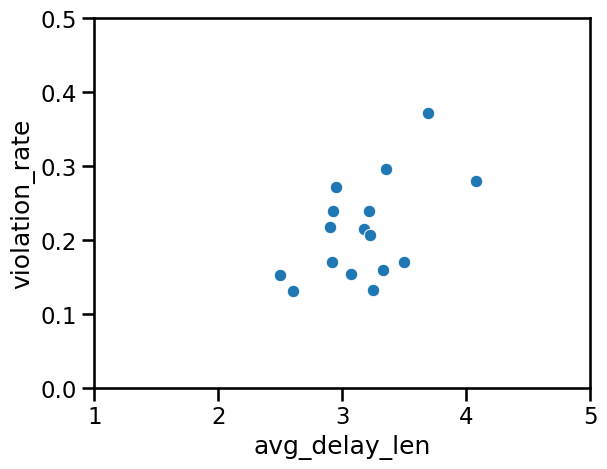

In [26]:
sns.scatterplot(data=data, x="avg_delay_len", y="violation_rate")
plt.xlim(1, 5)
plt.ylim(0, 0.5)

Average delay length and violation rate are highly correlated. What might make more sense to do here is try to predict an animals violation rate. That is the variable I care the most about anyway and I think I will have less issue with highly correlated features

In [84]:
data.to_csv("../data/processed/from_eda/02_predict_trained_hit.csv", index=False)

## Predicting Violations- Overall

In [5]:
data = pd.read_csv(
    "../data/processed/from_eda/01_trained_session_avg_hit_viol_rates.csv"
).drop(columns=["trained_violation"])


data["violation_rate"] = data["animal_id"].map(
    full_df.groupby(["animal_id", "session"])
    .violation.mean()
    .reset_index()
    .groupby("animal_id")
    .violation.mean()
)

full_df["prev_trial_not_started"] = full_df["n_prev_trial_not_started"] > 0
data["prev_trial_not_started_rate"] = data["animal_id"].map(
    full_df.groupby(["animal_id", "session"])
    .prev_trial_not_started.mean()
    .reset_index()
    .groupby("animal_id")
    .prev_trial_not_started.mean()
)


data["avg_delay_len"] = data["animal_id"].map(
    full_df.query("training_stage >=3")
    .groupby(["animal_id", "session"])
    .delay_time.mean()
    .reset_index()
    .groupby("animal_id")
    .delay_time.mean()
)

# rig id changed
full_df["rig_id_changed"] = (
    full_df.groupby(["animal_id"])["rig_id"].diff().ne(0).astype(int)
)
data["n_rig_switch"] = data["animal_id"].map(
    full_df.groupby("animal_id")["rig_id_changed"].sum()
)


data.head()

,animal_id,trained_hit,violation_rate,prev_trial_not_started_rate,avg_delay_len,n_rig_switch
0,W051,0.796836,0.159630,0.013793,3.331276,23
1,W060,0.825368,0.154347,0.011426,3.071942,22
2,W065,0.775634,0.372807,0.096513,3.690211,7
3,W066,0.788768,0.280227,0.036832,4.078185,10
4,W068,0.778252,0.214737,0.020789,3.174428,7


Here I'm going to use some more thoughtful variables- rather than number of rigs, I want to look at the number of times an animal switched since that is actually more of the problem than the number of rigs. Perhaps the animals with more rigs were phys animals and therefore much better- idk this just seems like a better feature.

The previous trial not started is how many time the animal had long itis in a session (> 200 s). These were encoded as timeout trials. See the dataset_alignment or cleaning notebooks for more information these. They represent, in some form, engagement in the task and are highly correlated with violation rate

<Axes: >

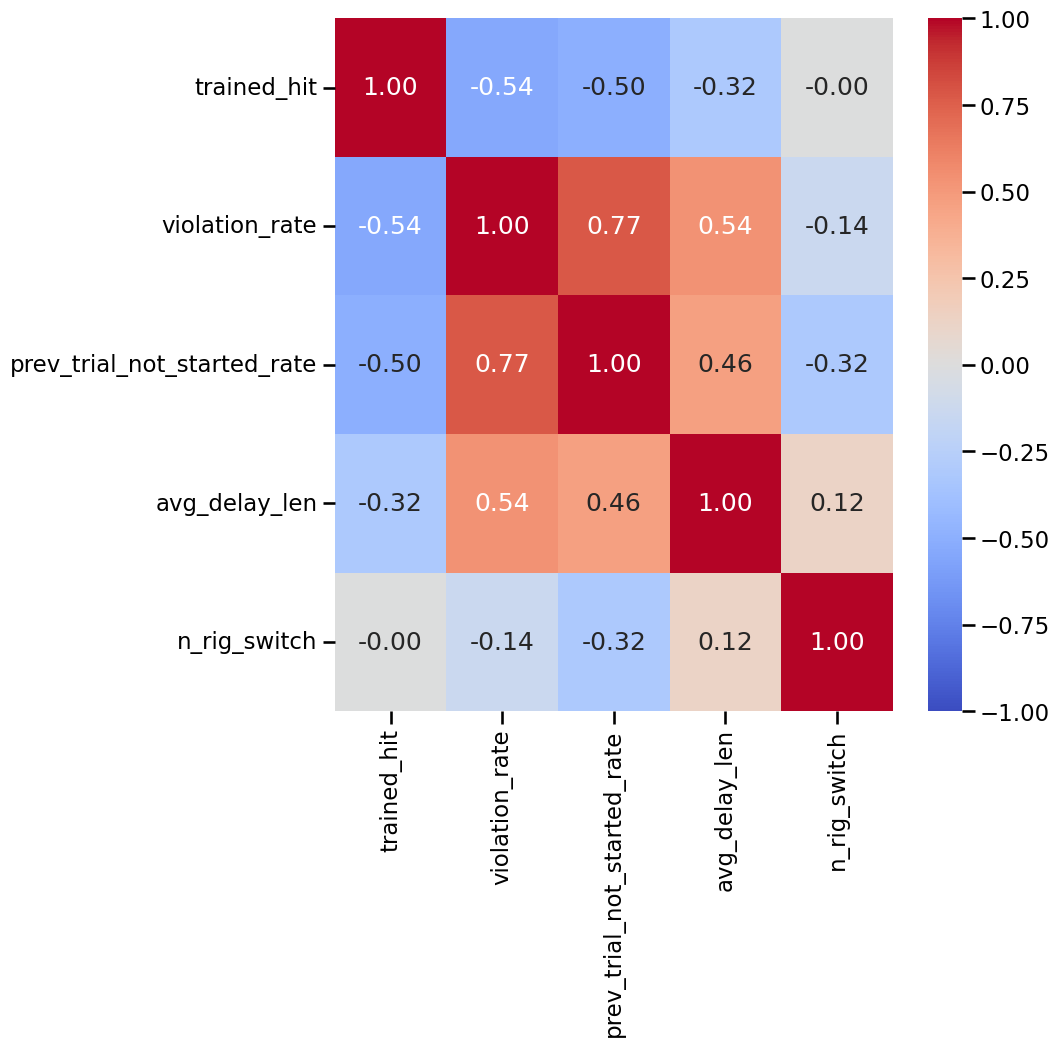

In [8]:
data_corr = data.drop(columns="animal_id").corr()

fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(
    data_corr,
    center=0,
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
)

### Predict

/Users/jessbreda/Desktop/github/animal-learning/src/multiglm/models/linear_regression.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


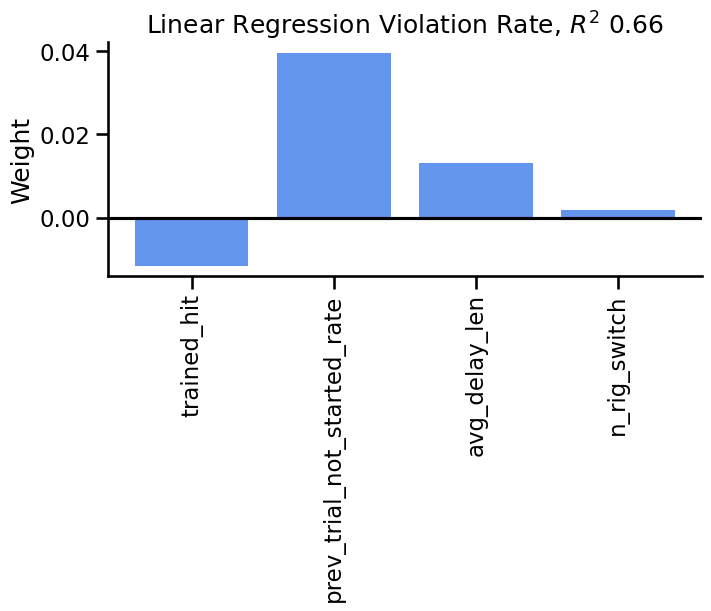

In [9]:
features = [
    column
    for column in data.columns.tolist()
    if column not in ["animal_id", "violation_rate", "n_rigs"]
]

predictor = "violation_rate"

model, predict, rsq, rns, ws = fit_linear_model(
    data, predictor, features, whiten=True, plot=False
)

fig, ax = plt.subplots(1, 1, figsize=(7, 6), constrained_layout=True)
plot_weights(
    ax,
    rns,
    ws,
    f"Linear Regression Violation Rate, $R^2$ {rsq:.2f}",
    color="cornflowerblue",
)
sns.despine()

Okay- this is a bit easier to digest than previous mdoels. We see the negative correlation with hit rate and violation rate that consistently pops up. Previous long itis are highly correlated with violations. Same with average delay length that an animal sees. This makes sense as it is the motor demands of the task. The number of rig switches has a positive weight but it is very small.

Let's see if/how results differ if predicting the trained violation rate rather than the overall.

In [10]:
data.to_csv("../data/processed/from_eda/02_predict_overall_violation.csv", index=False)

## Predicting Violations- Trained

In [19]:
data = pd.read_csv(
    "../data/processed/from_eda/01_trained_session_avg_hit_viol_rates.csv"
)


full_df["prev_trial_not_started"] = full_df["n_prev_trial_not_started"] > 0
data["prev_trial_not_started_rate"] = data["animal_id"].map(
    full_df.groupby(["animal_id", "session"])
    .prev_trial_not_started.mean()
    .reset_index()
    .groupby("animal_id")
    .prev_trial_not_started.mean()
)


data["avg_delay_len"] = data["animal_id"].map(
    full_df.query("training_stage >=3")
    .groupby(["animal_id", "session"])
    .delay_time.mean()
    .reset_index()
    .groupby("animal_id")
    .delay_time.mean()
)

# rig id changed
full_df["rig_id_changed"] = (
    full_df.groupby(["animal_id"])["rig_id"].diff().ne(0).astype(int)
)
data["n_rig_switch"] = data["animal_id"].map(
    full_df.groupby("animal_id")["rig_id_changed"].sum()
)


data.head()

,animal_id,trained_hit,trained_violation,prev_trial_not_started_rate,avg_delay_len,n_rig_switch
0,W051,0.796836,0.154370,0.013793,3.331276,23
1,W060,0.825368,0.149891,0.011426,3.071942,22
2,W065,0.775634,0.260626,0.096513,3.690211,7
3,W066,0.788768,0.253332,0.036832,4.078185,10
4,W068,0.778252,0.163857,0.020789,3.174428,7


Here I'm going to use some more thoughtful variables- rather than number of rigs, I want to look at the number of times an animal switched since that is actually more of the problem than the number of rigs. Perhaps the animals with more rigs were phys animals and therefore much better- idk this just seems like a better feature.

The previous trial not started is how many time the animal had long itis in a session (> 200 s). These were encoded as timeout trials. See the dataset_alignment or cleaning notebooks for more information these. They represent, in some form, engagement in the task and are highly correlated with violation rate

<Axes: >

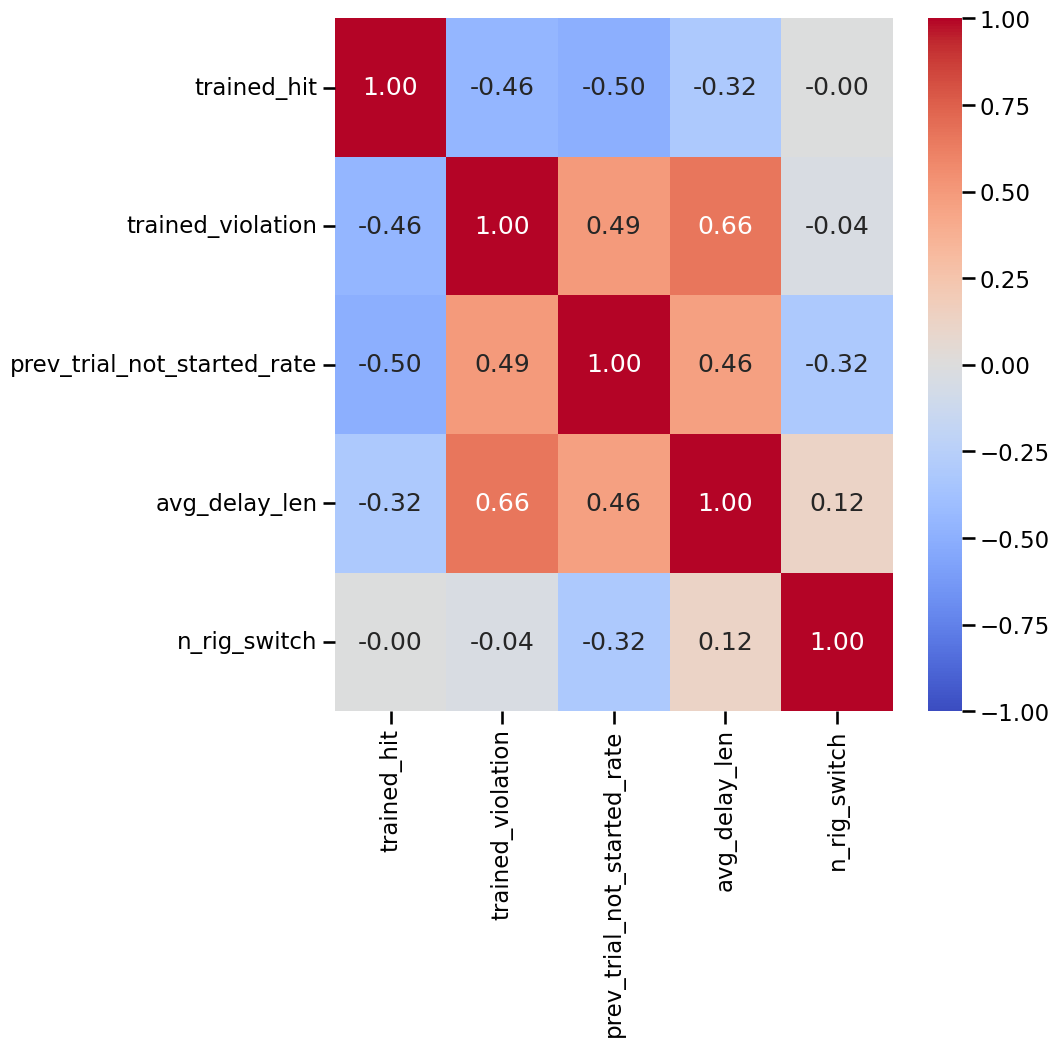

In [20]:
data_corr = data.drop(columns="animal_id").corr()

fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(
    data_corr,
    center=0,
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
)

### Predict

/Users/jessbreda/Desktop/github/animal-learning/src/multiglm/models/linear_regression.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


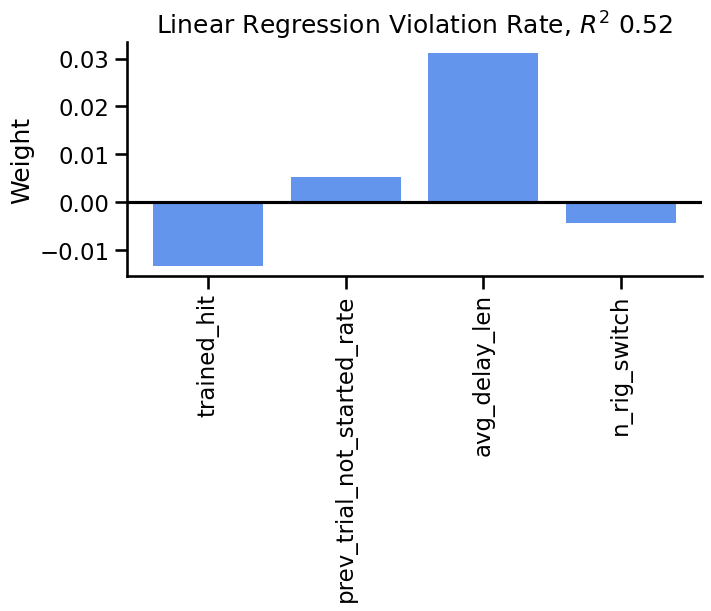

In [14]:
features = [
    column
    for column in data.columns.tolist()
    if column not in ["animal_id", "trained_violation", "n_rigs"]
]

predictor = "trained_violation"

model, predict, rsq, rns, ws = fit_linear_model(
    data, predictor, features, whiten=True, plot=False
)

fig, ax = plt.subplots(1, 1, figsize=(7, 6), constrained_layout=True)
plot_weights(
    ax,
    rns,
    ws,
    f"Linear Regression Violation Rate, $R^2$ {rsq:.2f}",
    color="cornflowerblue",
)
sns.despine()

This is very interesting- the iti has a much smaller effect for the trained violation rate than the overall violation rate. This value was created across all sessions. Maybe it's best to only use the trained_df to create it if predicting a trained violation rate? I'm not sure. I think this warrants some more investigation as appears these two variables will be used together as regressors

### Predicting Violation Rate- Trained + trained previous trial not stated

In [17]:
data = pd.read_csv(
    "../data/processed/from_eda/01_trained_session_avg_hit_viol_rates.csv"
)


trained_df["prev_trial_not_started"] = trained_df["n_prev_trial_not_started"] > 0
data["prev_trial_not_started_rate"] = data["animal_id"].map(
    trained_df.groupby(["animal_id", "session"])
    .prev_trial_not_started.mean()
    .reset_index()
    .groupby("animal_id")
    .prev_trial_not_started.mean()
)


data["avg_delay_len"] = data["animal_id"].map(
    full_df.query("training_stage >=3")
    .groupby(["animal_id", "session"])
    .delay_time.mean()
    .reset_index()
    .groupby("animal_id")
    .delay_time.mean()
)

# rig id changed
full_df["rig_id_changed"] = (
    full_df.groupby(["animal_id"])["rig_id"].diff().ne(0).astype(int)
)
data["n_rig_switch"] = data["animal_id"].map(
    full_df.groupby("animal_id")["rig_id_changed"].sum()
)


data.head()

,animal_id,trained_hit,trained_violation,prev_trial_not_started_rate,avg_delay_len,n_rig_switch
0,W051,0.796836,0.154370,0.011521,3.331276,23
1,W060,0.825368,0.149891,0.011817,3.071942,22
2,W065,0.775634,0.260626,0.013570,3.690211,7
3,W066,0.788768,0.253332,0.001851,4.078185,10
4,W068,0.778252,0.163857,0.014278,3.174428,7


/Users/jessbreda/Desktop/github/animal-learning/src/multiglm/models/linear_regression.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


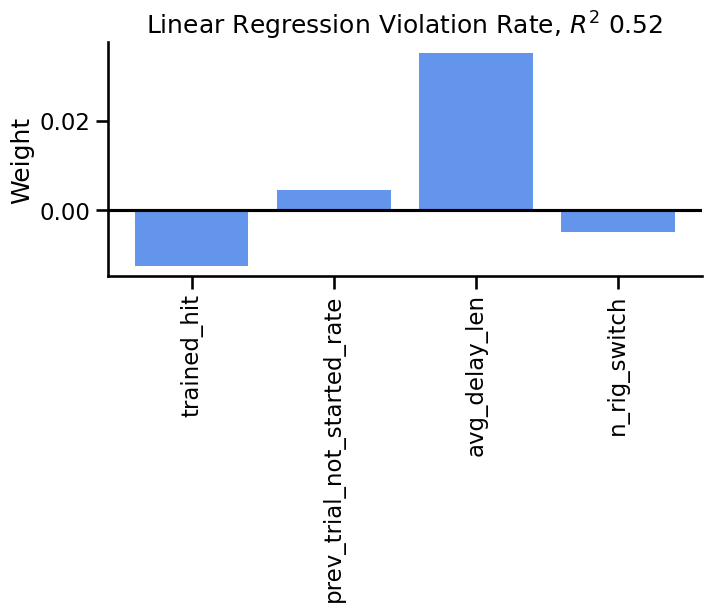

In [18]:
features = [
    column
    for column in data.columns.tolist()
    if column not in ["animal_id", "trained_violation", "n_rigs"]
]

predictor = "trained_violation"

model, predict, rsq, rns, ws = fit_linear_model(
    data, predictor, features, whiten=True, plot=False
)

fig, ax = plt.subplots(1, 1, figsize=(7, 6), constrained_layout=True)
plot_weights(
    ax,
    rns,
    ws,
    f"Linear Regression Violation Rate, $R^2$ {rsq:.2f}",
    color="cornflowerblue",
)
sns.despine()

Nope- it's not the trained aspect of it. That's interesting. When creating the regressor will really need to look into this more.